# Case Study: Jokes

In this case study we find out if we can make ourselves funnier by analysing jokes from a database.

The case study is divided into several parts:
- Goals
- Parsing
- Preparation (cleaning)
- Processing
- Exploration
- Visualization
- Conclusion

## Goals

In this section we define questions that will be our guideline througout the case study

- What jokes are funny?
- Can we find types of jokes?
- Would a joke recommender work?

We'll (try to) keep these question in mind when performing the case study.

## Parsing

we start out by importing all necessary libraries

In [1]:
import os
import json
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')

/tmp/ipykernel_8969/4057771804.py:10: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


in order to download datasets from kaggle, we need an API key to access their API, we'll make that here

In [2]:
if not os.path.exists(os.path.expanduser('~/.kaggle')):
    os.mkdir(os.path.expanduser('~/.kaggle'))

with open(os.path.expanduser('~/.kaggle/kaggle.json'), 'w') as f:
    json.dump(
        {
            "username":"lorenzf",
            "key":"7a44a9e99b27e796177d793a3d85b8cf"
        }
        , f)

now we can import kaggle too and download the datasets

In [3]:
import kaggle
kaggle.api.dataset_download_files(dataset='pavellexyr/one-million-reddit-jokes', path='./data', unzip=True)

ModuleNotFoundError: No module named 'kaggle'

the csv files are now in the './data' folder, we can now read them using pandas, here is the list of all csv files in our folder

In [4]:
os.listdir('./data')

['WA_Fn-UseC_-Telco-Customer-Churn.csv',
 'API_NY.GDP.PCAP.CD_DS2_en_csv_v2_3358201.csv',
 'noc_regions.csv',
 'freeFormResponses.csv',
 'SurveySchema.csv',
 'jester_ratings.csv',
 'multipleChoiceResponses.csv',
 'one-million-reddit-jokes.csv',
 'jester_items.csv',
 'athlete_events.csv',
 'API_SP.POP.TOTL_DS2_en_csv_v2_3358390.csv']

With only one file in the dataset, we import it.

In [5]:
reddit_jokes_df = pd.read_csv('./data/one-million-reddit-jokes.csv')
print('shape: ' + str(reddit_jokes_df.shape))
reddit_jokes_df.head()

shape: (1000000, 12)


,type,id,subreddit.id,subreddit.name,subreddit.nsfw,created_utc,permalink,domain,url,selftext,title,score
0,post,ftbp1i,2qh72,jokes,False,1585785543,https://old.reddit.com/r/Jokes/comments/ftbp1i...,self.jokes,NaN,My corona is covered with foreskin so it is no...,I am soooo glad I'm not circumcised!,2
1,post,ftboup,2qh72,jokes,False,1585785522,https://old.reddit.com/r/Jokes/comments/ftboup...,self.jokes,NaN,It's called Google Sheets.,Did you know Google now has a platform for rec...,9
2,post,ftbopj,2qh72,jokes,False,1585785508,https://old.reddit.com/r/Jokes/comments/ftbopj...,self.jokes,NaN,The vacuum doesn't snore after sex.\n\n&amp;#x...,What is the difference between my wife and my ...,15
3,post,ftbnxh,2qh72,jokes,False,1585785428,https://old.reddit.com/r/Jokes/comments/ftbnxh...,self.jokes,NaN,[removed],My last joke for now.,9
4,post,ftbjpg,2qh72,jokes,False,1585785009,https://old.reddit.com/r/Jokes/comments/ftbjpg...,self.jokes,NaN,[removed],The Nintendo 64 turns 18 this week...,134


Already we can see a lot of unnecessary information, so cleanup is important. It seems the joke is divided in a title and selftext where often the punchline is present.

## Preparation

here we perform tasks to prepare the data in a more pleasing format.

### Cleanup

First thing I would like to do see which columns are useless, by printing the amount of unique values

In [6]:
for col in reddit_jokes_df.columns:
    print(col)
    print(reddit_jokes_df[col].nunique())
    print()

type
1

id
1000000

subreddit.id
1

subreddit.name
1

subreddit.nsfw
1

created_utc
996373

permalink
1000000

domain
364

url
4410

selftext
520567

title
861254

score
8913



a few columns only have 1 value, also the links are not important for our case, so we drop them too.

In [7]:
reddit_jokes_df = reddit_jokes_df.drop(columns=['type', 'id', 'subreddit.id', 'subreddit.name', 'subreddit.nsfw', 'permalink', 'url'])
reddit_jokes_df.head()

,created_utc,domain,selftext,title,score
0,1585785543,self.jokes,My corona is covered with foreskin so it is no...,I am soooo glad I'm not circumcised!,2
1,1585785522,self.jokes,It's called Google Sheets.,Did you know Google now has a platform for rec...,9
2,1585785508,self.jokes,The vacuum doesn't snore after sex.\n\n&amp;#x...,What is the difference between my wife and my ...,15
3,1585785428,self.jokes,[removed],My last joke for now.,9
4,1585785009,self.jokes,[removed],The Nintendo 64 turns 18 this week...,134


much cleaner already!

### Data Types

Before we do anything with our data, it is good to see if our data types are in order

In [8]:
reddit_jokes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 5 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   created_utc  1000000 non-null  int64 
 1   domain       1000000 non-null  object
 2   selftext     995525 non-null   object
 3   title        1000000 non-null  object
 4   score        1000000 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 38.1+ MB


the created_utc feature is encoded in an unix timestamp, it would be more usefull to transform it to a timestamp

In [9]:
reddit_jokes_df['created'] = pd.to_datetime(reddit_jokes_df['created_utc'], unit='s')
del reddit_jokes_df['created_utc']
reddit_jokes_df.head()

,domain,selftext,title,score,created
0,self.jokes,My corona is covered with foreskin so it is no...,I am soooo glad I'm not circumcised!,2,2020-04-01 23:59:03
1,self.jokes,It's called Google Sheets.,Did you know Google now has a platform for rec...,9,2020-04-01 23:58:42
2,self.jokes,The vacuum doesn't snore after sex.\n\n&amp;#x...,What is the difference between my wife and my ...,15,2020-04-01 23:58:28
3,self.jokes,[removed],My last joke for now.,9,2020-04-01 23:57:08
4,self.jokes,[removed],The Nintendo 64 turns 18 this week...,134,2020-04-01 23:50:09


### Missing values

for each dataframe we apply a few checks in order to see the quality of data

In [10]:
print(100*reddit_jokes_df.isna().sum()/reddit_jokes_df.shape[0])

domain      0.0000
selftext    0.4475
title       0.0000
score       0.0000
created     0.0000
dtype: float64


it looks like some jokes are missing the selftext field, we show a few here.

In [11]:
reddit_jokes_df[reddit_jokes_df.selftext.isna()].sort_values(by='score', ascending=False)

,domain,selftext,title,score,created
625315,imgur.com,NaN,The funniest /r/jokes has ever been,67950,2017-05-20 15:41:28
971313,self.jokes,NaN,Ellen Pao's career,36918,2015-07-03 15:41:05
942471,self.jokes,NaN,"If a woman sleeps with a bunch of guys, she's ...",17486,2015-10-05 16:09:09
926550,self.jokes,NaN,One in every 2 and a half men is HIV positive.,17456,2015-11-18 04:29:54
919422,self.jokes,NaN,"Accordion to a recent survey, replacing words ...",12580,2015-12-07 18:55:27
...,...,...,...,...,...
929807,self.jokes,NaN,9gag,0,2015-11-09 03:33:22
959394,self.jokes,NaN,Like flaming globes of Sigmund,0,2015-08-14 13:40:21
929809,self.jokes,NaN,"On a scale of 10 to 10, how good am I at givin...",0,2015-11-09 03:26:55
959338,self.jokes,NaN,Who is Julius Caesar's favorite singer? Mark A...,0,2015-08-14 17:03:55


as far as I can see here the jokes are so short they are only one sentence, so we can fill in the missing values with an empty text.

In [12]:
reddit_jokes_df.selftext = reddit_jokes_df.selftext.fillna('')

This does not mean we are done, earlier I noticed the words [removed] and [deleted] in the selftext feature, indicating the joke was removed or deleted, these are missing values!

In [13]:
reddit_jokes_df[reddit_jokes_df.selftext.isin(['[removed]', '[deleted]'])].head()

,domain,selftext,title,score,created
3,self.jokes,[removed],My last joke for now.,9,2020-04-01 23:57:08
4,self.jokes,[removed],The Nintendo 64 turns 18 this week...,134,2020-04-01 23:50:09
5,self.jokes,[removed],Sex with teacher.,1,2020-04-01 23:49:55
6,self.jokes,[removed],Another long one.,8,2020-04-01 23:44:11
8,self.jokes,[removed],A Priest takes a walk down to the docks one day,88,2020-04-01 23:39:27


I am going to remove these jokes as they are not complete anymore, it might have been that these jokes have been removed as they have already been posted.

In [14]:
reddit_jokes_df = reddit_jokes_df[~reddit_jokes_df.selftext.isin(['[removed]', '[deleted]'])]
reddit_jokes_df.shape

(578637, 5)

seems we have kept about 578k jokes, not bad!

### Duplicates

As formatting of text might be different i'm not expecting a lot of duplicates, let's see what we can find.

In [15]:
reddit_jokes_df[reddit_jokes_df.duplicated(subset=['title', 'selftext'])]

,domain,selftext,title,score,created
211,self.jokes,An academia nut..,What do you call a nut that gets good grades?,5,2020-04-01 18:54:06
4452,self.jokes,Repossssssssst,If a snake who is on reddit has to comment a r...,0,2020-03-27 09:16:20
6349,self.jokes,"“To Japan,” replies her husband. \n\n“Oh my! T...",A woman asks her husband where he’s taking the...,4,2020-03-25 00:48:09
6881,self.jokes,"Fortunately, I belong to the 1% of intelligent...",99.9% of people are idiots.,45135,2020-03-24 09:40:14
8299,self.jokes,You tell it a shitty joke.,How do you get a toilet to laugh?,0,2020-03-22 07:49:45
...,...,...,...,...,...
999779,self.jokes,Dam.,What did the fish say when he hit the wall?,25,2015-03-27 10:33:12
999851,self.jokes,He tractor down.,How did the farmer find his wife?,58,2015-03-27 02:42:29
999882,self.jokes,,women's rights,0,2015-03-27 00:48:36
999936,self.jokes,"Don't be stupid, feminists can't change anything",How many feminists does it take to change a li...,24,2015-03-26 22:00:06


A fair amount of jokes are reposted, so we keep the ones with the highest score.

In [16]:
 reddit_jokes_df = reddit_jokes_df.sort_values('score').drop_duplicates(subset=['title', 'selftext'], keep='last').reset_index()

### Text formatting

Before we can analyze the text in the jokes we have to format it. We can do this by removing all special character and changing it all to lowercase

In [17]:
for col in ['selftext', 'title']:
    reddit_jokes_df[col] = reddit_jokes_df[col].replace(to_replace="[^a-zA-Z,.!? ]", value="", regex=True).str.lower()

reddit_jokes_df.head()

,index,domain,selftext,title,score,created
0,630580,self.jokes,"those who need closure,",there are two kinds of people in the world.,0,2017-05-12 17:01:44
1,187066,self.jokes,so when someone asks you can say its .,set your wifi password to,0,2019-05-28 00:30:46
2,437464,self.jokes,tooth hurty!,at what time do you see your dentist?,0,2018-03-28 10:17:26
3,714598,self.jokes,where did you get a phone that works in spaini...,john and juan are on lunch break when juans ph...,0,2017-01-13 02:37:59
4,187072,self.jokes,me how many am i allowed?guy only one me well ...,a guy is handing out free fake mustaches on th...,0,2019-05-28 00:20:01


Next we create a single joke by combining the title and selftext, this makes it easier to operate.

In [18]:
reddit_jokes_df['joke'] = reddit_jokes_df.title + ' ' + reddit_jokes_df.selftext
reddit_jokes_df = reddit_jokes_df.drop(columns=['title', 'selftext'])
reddit_jokes_df.head()

,index,domain,score,created,joke
0,630580,self.jokes,0,2017-05-12 17:01:44,there are two kinds of people in the world. th...
1,187066,self.jokes,0,2019-05-28 00:30:46,set your wifi password to so when someone ask...
2,437464,self.jokes,0,2018-03-28 10:17:26,at what time do you see your dentist? tooth hu...
3,714598,self.jokes,0,2017-01-13 02:37:59,john and juan are on lunch break when juans ph...
4,187072,self.jokes,0,2019-05-28 00:20:01,a guy is handing out free fake mustaches on th...


## Processing

### Timing of joke

I would like to know if the timing of the jokes makes an impact on how funny the joke is, so i grouped based on both the weekday as well as the hour of day.

In [19]:
reddit_jokes_weekday = reddit_jokes_df.groupby(reddit_jokes_df.created.dt.weekday).score.agg(['mean', 'count'])
reddit_jokes_weekday

,mean,count
created,,
0,226.871773,79866
1,228.808886,82940
2,222.802165,84793
3,215.771594,84932
4,222.888666,82634
5,232.752534,75089
6,241.322581,75516


In [20]:
reddit_jokes_hour = reddit_jokes_df.groupby(reddit_jokes_df.created.dt.hour).score.agg(['mean', 'count'])
reddit_jokes_hour

,mean,count
created,,
0,189.177767,25646
1,189.383726,25440
2,172.406772,25368
3,140.741126,23637
4,144.066960,21162
5,137.355467,19006
6,168.542319,16671
7,214.903014,15198
8,271.710558,14217


### Bag of words
To be able to work with the words in our joke, we create a bag of words dataframe, where for each word and joke combination a count is kept of how many times the word is present in that joke. Notice that stopwords are removed.

First we split each joke up in words

In [21]:
joke_words = reddit_jokes_df.joke.str.split(' ')
joke_words.head()

0    [there, are, two, kinds, of, people, in, the, ...
1    [set, your, wifi, password, to, , so, when, so...
2    [at, what, time, do, you, see, your, dentist?,...
3    [john, and, juan, are, on, lunch, break, when,...
4    [a, guy, is, handing, out, free, fake, mustach...
Name: joke, dtype: object

Next we use the nltk toolkit to get a list of english stopwords.

In [22]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords.words('english')[:5]

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/lorenzf/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i', 'me', 'my', 'myself', 'we']

We remove all the stopwords from the jokes, now the jokes have a handicapped grammar.

In [23]:
joke_words = joke_words.head().apply(lambda x : [word for word in x if word not in stopwords.words('english')])
joke_words.head()

0         [two, kinds, people, world., need, closure,]
1       [set, wifi, password, , someone, asks, say, .]
2                 [time, see, dentist?, tooth, hurty!]
3    [john, juan, lunch, break, juans, phone, rings...
4    [guy, handing, free, fake, mustaches, street, ...
Name: joke, dtype: object

Finally we are going to use sklearn and the CountVectorizer to create the BoW vector, this is a sparse matrix as most words are not appearing in most jokes.
This means we cannot visualise the matrix, or our computer would explode.

In [24]:
from sklearn.feature_extraction.text import CountVectorizer

cnt_vect = CountVectorizer(analyzer="word", stop_words=stopwords.words('english'), max_features=20000) 

bow_jokes = cnt_vect.fit_transform(reddit_jokes_df.joke.values)

In [25]:
bow_jokes

<565770x20000 sparse matrix of type '<class 'numpy.int64'>'
	with 9101120 stored elements in Compressed Sparse Row format>

But we can fetch the vocabulary of our bag, which starts with a lot of weird words, indicating we might have chosen too many features

In [26]:
cnt_vect.get_feature_names_out()[:10]

array(['aa', 'aaa', 'aaah', 'aah', 'aardvark', 'aaron', 'ab', 'aback',
       'abacus', 'abandon'], dtype=object)

### Term Frequency - Inverse Document Frequency
Another interesting method is the tf-idf matrix, where each occurence is weighted by the overall frequency of that word. If a word is used often over all jokes, it won't be as important, but if a word is used infrequent it is more important.

Again we use sklearn to vectorize our jokes

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer()
tfidf_jokes = tfidf_vect.fit_transform(reddit_jokes_df.joke.values)
tfidf_jokes

<565770x196601 sparse matrix of type '<class 'numpy.float64'>'
	with 15153814 stored elements in Compressed Sparse Row format>

we can create a quick dataframe to interpret the result, for each word in our dataset we retrieve the inverse document frequency, a high idf means a unique word.

In [28]:
idf = pd.DataFrame(
    {
      'term': tfidf_vect.get_feature_names_out(),
      'idf': tfidf_vect.idf_,
    }
)
idf.head()

,term,idf
0,aa,10.026437
1,aaa,10.275653
2,aaaa,12.454185
3,aaaaa,13.147332
4,aaaaaa,13.552798


When we sort them by idf we can find the most unique words, yet it doesn't seem to be useful at the moment.

In [29]:
idf.sort_values(by='idf', ascending=False).head(10)

,term,idf
196600,zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzthe,13.552798
110080,misterunderstanding,13.552798
110074,misterectomy,13.552798
110075,misterious,13.552798
110076,misterjmyers,13.552798
110077,misterlee,13.552798
110078,misterogyny,13.552798
110079,misters,13.552798
110081,misterunderstood,13.552798
110072,misterapproximate,13.552798


## Exploration

In [30]:
good_jokes = reddit_jokes_df[reddit_jokes_df.score>10000].copy()
good_jokes

,index,domain,score,created,joke
562291,766392,self.jokes,10003,2016-11-05 12:19:21,a joke my grandma told me before she passed. s...
562292,817060,self.jokes,10013,2016-08-15 23:23:22,"if a woman sleeps with men shes a slut, but i..."
562293,956485,self.jokes,10017,2015-08-23 14:31:29,how many germans does it take to change a ligh...
562294,672977,self.jokes,10018,2017-03-12 10:30:11,a man and his wife are awakened at oclock in ...
562295,207962,self.jokes,10019,2019-04-24 23:06:14,my least favorite color is purple. i hate it m...
...,...,...,...,...,...
565765,329338,self.jokes,98257,2018-10-08 13:53:47,a new navy recruit has his first day on the su...
565766,141894,self.jokes,103652,2019-08-10 15:03:25,if your surprised that jeffrey epstein commite...
565767,596220,self.jokes,106412,2017-07-05 18:01:05,v vedit seems like the ctrl key on my keyboard...
565768,511072,self.jokes,136359,2017-11-21 20:15:27,calm down about the net neutrality thing... pa...


In [31]:
good_jokes_word_cnt = pd.concat(
    [
        pd.Series(cnt_vect.get_feature_names_out()),
        pd.Series(np.asarray(bow_jokes[good_jokes.index].sum(axis=0)).squeeze()),
    ], axis='columns', keys=['word', 'count']
)
good_jokes_word_cnt

,word,count
0,aa,1
1,aaa,3
2,aaah,0
3,aah,0
4,aardvark,0
...,...,...
19995,zoos,0
19996,zs,0
19997,zucchini,0
19998,zuckerberg,1


In [32]:
good_jokes_word_cnt.sort_values('count', ascending=False).head(20)

,word,count
15199,says,1647
10528,man,1405
15050,said,1196
12100,one,1057
8673,im,833
7278,get,717
19559,wife,669
10101,like,656
5190,dont,632
19416,well,626


In [33]:
for joke in good_jokes[good_jokes.joke.str.contains(' man ')].tail(5).joke:
    print(joke)
    print()

a man in an interrogation room says im not saying a word without my lawyer present. cop you are the lawyer. lawyer exactly, so wheres my present?

christmas joke nsfw a  year old male walks into a drug store. he says ive been invited to christmas dinner at my new girlfriends house. afterwards i hope there is a chance i get lucky, you know what i mean clerk how about condoms then? they could come in handy. heres a pack. the young man after paying walks to the door, stops, smiles, comes back you know what, the mom is also smoking hot, i think ill take another pack, just in case i get extra lucky.christmas eve comes around, the boy sits at the dinner table and doesnt say a word. after a while his girlfriend says if i had known you were so quiet, i wouldnt have invited you. the young man replies if you had told me your dad works at a drug store, i wouldnt have come.

my favorite joke everyone knows dave dave was bragging to his boss one day, you know, i know everyone there is to know. just

In [34]:
good_jokes_word_idf = pd.concat(
    [
        pd.Series(tfidf_vect.get_feature_names_out()),
        pd.Series(np.asarray(tfidf_jokes[good_jokes.index].sum(axis=0)).squeeze()),
    ], axis='columns', keys=['word', 'count']
)
good_jokes_word_idf

,word,count
0,aa,0.218800
1,aaa,0.337332
2,aaaa,0.000000
3,aaaaa,0.000000
4,aaaaaa,0.000000
...,...,...
196596,zzzzzzzzzzzzzzzzz,0.000000
196597,zzzzzzzzzzzzzzzzzzzzzz,0.000000
196598,zzzzzzzzzzzzzzzzzzzzzzzzzzzzzthe,0.000000
196599,zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzthe,0.000000


In [35]:
good_jokes_word_idf[~good_jokes_word_idf.word.isin(stopwords.words('english'))].sort_values('count', ascending=False).head(20)

,word,count
147669,said,67.537998
149360,says,64.319957
103769,man,57.291711
85108,im,51.772732
190313,wife,51.119043
121680,one,50.363516
99600,like,44.929305
69195,get,43.785308
53561,edit,41.610126
50077,dont,41.495084


In [36]:
tfidf_good_vect = TfidfVectorizer()
tfidf_good_jokes = tfidf_good_vect.fit_transform(good_jokes.joke.values)
tfidf_good_jokes

<3479x13866 sparse matrix of type '<class 'numpy.float64'>'
	with 158145 stored elements in Compressed Sparse Row format>

In [37]:
good_jokes_word_idf = pd.concat(
    [
        pd.Series(tfidf_good_vect.get_feature_names_out()),
        pd.Series(np.asarray(tfidf_good_jokes.sum(axis=0)).squeeze()),
    ], axis='columns', keys=['word', 'count']
)
good_jokes_word_idf

,word,count
0,aa,0.217575
1,aaa,0.387436
2,aaaah,0.085922
3,aaarrrghh,0.316697
4,aaaway,0.318949
...,...,...
13861,zoobooks,0.237976
13862,zookeeper,0.409659
13863,zoophile,0.203000
13864,zuckerberg,0.352931


In [38]:
good_jokes_word_idf[~good_jokes_word_idf.word.isin(stopwords.words('english'))].sort_values('count', ascending=False).head(20)

,word,count
10299,said,61.751454
10407,says,60.323491
7268,man,58.135122
8314,one,49.662388
6025,im,49.230105
13533,wife,47.633648
6978,like,45.431302
5084,get,43.641674
3600,dont,40.811579
717,asked,36.849412


In [39]:
from sklearn.cluster import KMeans

In [40]:
kmeans = KMeans(n_clusters=100)
kmeans.fit(tfidf_good_jokes)

KMeans(n_clusters=100)

In [41]:
good_jokes['label'] = kmeans.labels_

In [42]:
good_jokes.head()

,index,domain,score,created,joke,label
562291,766392,self.jokes,10003,2016-11-05 12:19:21,a joke my grandma told me before she passed. s...,10
562292,817060,self.jokes,10013,2016-08-15 23:23:22,"if a woman sleeps with men shes a slut, but i...",35
562293,956485,self.jokes,10017,2015-08-23 14:31:29,how many germans does it take to change a ligh...,30
562294,672977,self.jokes,10018,2017-03-12 10:30:11,a man and his wife are awakened at oclock in ...,19
562295,207962,self.jokes,10019,2019-04-24 23:06:14,my least favorite color is purple. i hate it m...,73


In [43]:
jokes_cluster_counts = good_jokes.label.value_counts()
jokes_cluster_counts

22    356
19    312
5     211
10    166
65     95
     ... 
33      8
71      8
55      7
13      7
27      6
Name: label, Length: 100, dtype: int64

In [44]:
for joke in good_jokes[good_jokes.label==jokes_cluster_counts.index[0]].sort_values('score', ascending=False).joke.head():
    print(joke)
    print()

calm down about the net neutrality thing... paying additional money to access certain sites will give you a sense of pride and accomplishment.

why was the antivaxxers  year old child crying? midlife crisis

all countries eventually got coronavirus but china got it right off the bat.

as an aussie, americans are always asking me where in australia there isnt something trying to kill you... school is my answer 

a feminist told me about the dwayne johnson rule. the rule, as she explained it, was that in order to determine if a particular comment was appropriate to say to a woman, first ask yourself, would i be comfortable saying this to dwayne johnson? if not, dont say it.i thought this sounded like a good rule. so i told heryour chest is fucking epic.



In [45]:
for joke in good_jokes[good_jokes.label==jokes_cluster_counts.index[-1]].sort_values('score', ascending=False).joke.head():
    print(joke)
    print()

i take viagra for my sun burn... it doesnt cure it, but it keeps the sheets off my legs when i sleep.ampxb

what rhymes with orange no it doesnt

im taking viagra for my sunburn. it doesnt cure it, but it keeps the sheets off of my legs

ive been taking viagra for my sunburn doesnt cure it, but it keeps the sheets off my legs at night.

im taking viagra for my sunburn it doesnt cure it, but it keeps the sheets off my legs



In [46]:
kaggle.api.dataset_download_files(dataset='vikashrajluhaniwal/jester-17m-jokes-ratings-dataset', path='./data', unzip=True)

In [47]:
jester_jokes_df = pd.read_csv('./data/jester_items.csv')
print('shape: ' + str(jester_jokes_df.shape))
jester_jokes_df.head()

shape: (150, 2)


,jokeId,jokeText
0,1,"A man visits the doctor. The doctor says ""I ha..."
1,2,This couple had an excellent relationship goin...
2,3,Q. What's 200 feet long and has 4 teeth? \n\nA...
3,4,Q. What's the difference between a man and a t...
4,5,Q.\tWhat's O. J. Simpson's Internet address? \...


In [48]:
jester_ratings_df = pd.read_csv('./data/jester_ratings.csv')
print('shape: ' + str(jester_ratings_df.shape))
jester_ratings_df.head()

shape: (1761439, 3)


,userId,jokeId,rating
0,1,5,0.219
1,1,7,-9.281
2,1,8,-9.281
3,1,13,-6.781
4,1,15,0.875


In [49]:
jester_ratings_df.groupby('jokeId').rating.mean()

jokeId
5     -1.756331
7     -1.809230
8     -0.672010
13    -0.590224
15    -1.377098
         ...   
146    0.178280
147    1.783395
148    3.061760
149    2.399796
150    2.810758
Name: rating, Length: 140, dtype: float64

In [50]:
jester_sorted = jester_ratings_df.groupby('jokeId').rating.mean().to_frame().join(jester_jokes_df).sort_values('rating', ascending=False)
jester_sorted.head()

,rating,jokeId,jokeText
jokeId,,,
53,3.714381,54.0,"The Pope dies and, naturally, goes to heaven. ..."
105,3.711223,106.0,An engineer dies and reports to the pearly gat...
89,3.606506,90.0,Q: How many programmers does it take to change...
129,3.583496,130.0,An old man goes to the doctor for his yearly p...
35,3.560305,36.0,"A guy walks into a bar, orders a beer and says..."


In [51]:
for joke in jester_sorted.head().jokeText:
    print(joke)
    print('---')

The Pope dies and, naturally, goes to heaven. He's met by the reception
committee, and after a whirlwind tour he is told that he can enjoy any
of the myriad of recreations available.
He decides that he wants to read all of the ancient original text of the
Holy Scriptures, so he spends the next eon or so learning languages.
After becoming a linguistic master, he sits down in the library and
begins to pour over every version of the Bible, working back from most
recent "Easy Reading" to the original script.
All of a sudden there is a scream in the library. The Angels come
running in only to find the Pope huddled in his chair, crying to himself
and muttering, "An 'R'! The scribes left out the 'R'." 
A particularly concerned Angel takes him aside, offering comfort, asks
him what the problem is and what does he mean. 
After collecting his
wits, the Pope sobs again, "It's the letter 'R'. They left out the 'R'.
The word was supposed to be CELEBRATE!"

---
An engineer dies and reports to the pe

In [52]:
jester_ratings_pivot_df = jester_ratings_df.pivot(index='userId', columns='jokeId', values='rating')
jester_ratings_pivot_df.head()

jokeId,5,7,8,13,15,16,17,18,19,20,...,141,142,143,144,145,146,147,148,149,150
userId,,,,,,,,,,,,,,,,,,,,,
1,0.219,-9.281,-9.281,-6.781,0.875,-9.656,-9.031,-7.469,-8.719,-9.156,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-9.688,9.938,9.531,9.938,0.406,3.719,9.656,-2.688,-9.562,-9.125,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-9.844,-9.844,-7.219,-2.031,-9.938,-9.969,-9.875,-9.812,-9.781,-6.844,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-5.812,-4.500,-4.906,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6.906,4.750,-5.906,-0.406,-4.031,3.875,6.219,5.656,6.094,5.406,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
kmeans = KMeans(n_clusters=100)
kmeans.fit(jester_ratings_pivot_df.fillna(0))

KMeans(n_clusters=100)

In [54]:
user_clusters = pd.Series(kmeans.labels_, index=jester_ratings_pivot_df.index)
user_clusters

userId
1        18
2        42
3        64
4        37
5        15
         ..
63974    68
63975    56
63976    98
63977    85
63978    14
Length: 59132, dtype: int32

In [55]:
user_cluster_counts = user_clusters.value_counts()
user_cluster_counts

35    3806
98    2301
81    1884
37    1672
78    1655
      ... 
26      47
4       45
31       1
62       1
97       1
Length: 100, dtype: int64

In [56]:
users_set = set(user_clusters[user_clusters==user_cluster_counts.index[0]].index)
print(users_set)

{8193, 16389, 7, 24583, 57354, 16395, 32779, 57356, 24592, 57363, 32791, 24601, 16414, 24606, 32801, 49185, 8232, 16425, 24618, 43, 24619, 24621, 49193, 41012, 24631, 58, 24634, 8252, 24638, 24642, 16453, 24647, 49223, 8265, 57421, 49230, 49233, 82, 24659, 24660, 49235, 24663, 24664, 57431, 24666, 32861, 41057, 24678, 57448, 32873, 24683, 116, 16501, 41080, 24700, 125, 16510, 32894, 32895, 8321, 24705, 32898, 8324, 8328, 24714, 16523, 49294, 49295, 24720, 41104, 49297, 49300, 32917, 41109, 57496, 8347, 32923, 41115, 32926, 49309, 8352, 49312, 24746, 32938, 24749, 24750, 32945, 8370, 24756, 49335, 57527, 41149, 57537, 41156, 24778, 24780, 41168, 8406, 49367, 41176, 57559, 49371, 41188, 41189, 57572, 41194, 33007, 24823, 24825, 41211, 49408, 33029, 262, 49416, 33034, 41227, 57613, 16656, 57619, 16660, 16661, 8470, 33045, 24856, 33049, 49428, 283, 49434, 57629, 24865, 8482, 41251, 16676, 49448, 24877, 41264, 8499, 16691, 311, 49467, 16701, 24895, 8515, 324, 49475, 41288, 8524, 41296, 4948

In [57]:
jester_group_sorted = jester_ratings_df[jester_ratings_df.userId.isin(users_set)].groupby('jokeId').rating.mean().to_frame().join(jester_jokes_df).sort_values('rating', ascending=False)
jester_group_sorted.head()

,rating,jokeId,jokeText
jokeId,,,
53,1.457240,54.0,"The Pope dies and, naturally, goes to heaven. ..."
114,1.289011,115.0,A lady bought a new Lexus. It cost a bundle. T...
50,1.147600,51.0,Did you hear that Clinton has announced there ...
126,1.140983,127.0,"A little boy goes to his dad and asks, ""What i..."
89,1.136812,90.0,Q: How many programmers does it take to change...


In [58]:
users_set = set(user_clusters[user_clusters==user_cluster_counts.index[-5]].index)
jester_group_sorted = jester_ratings_df[jester_ratings_df.userId.isin(users_set)].groupby('jokeId').rating.mean().to_frame().join(jester_jokes_df).sort_values('rating', ascending=False)
jester_group_sorted.head()

,rating,jokeId,jokeText
jokeId,,,
80,9.469000,81.0,An Asian man goes into a New York CityBank to ...
73,8.937500,74.0,Q: How many stalkers does it take to change a ...
116,7.938000,117.0,A man joins a big corporate empire as a traine...
106,7.290574,107.0,(A) The Japanese eat very little fat and suffe...
63,7.135891,64.0,What is the rallying cry of the International ...


In [59]:
kmeans.inertia_

30322545.978758477

In [60]:
kmeans = KMeans(n_clusters=200)
kmeans.fit(jester_ratings_pivot_df.fillna(0))

KMeans(n_clusters=200)

In [61]:
kmeans.inertia_

28653640.838373728

In [62]:
user_clusters = pd.Series(kmeans.labels_, index=jester_ratings_pivot_df.index)
user_clusters.value_counts()

43     3134
110    2009
7      1161
1      1059
118    1038
       ... 
116       1
115       1
80        1
158       1
125       1
Length: 200, dtype: int64

In [63]:
users_set = set(user_clusters[user_clusters==49].index)
jester_group_sorted = jester_ratings_df[jester_ratings_df.userId.isin(users_set)].groupby('jokeId').rating.mean().to_frame().join(jester_jokes_df).sort_values('rating', ascending=False)
jester_group_sorted.head()

,rating,jokeId,jokeText
jokeId,,,
27,4.927000,28.0,"A mechanical, electrical and a software engine..."
116,4.562000,117.0,A man joins a big corporate empire as a traine...
8,1.609726,9.0,A country guy goes into a city bar that has a ...
50,1.509039,51.0,Did you hear that Clinton has announced there ...
53,1.463231,54.0,"The Pope dies and, naturally, goes to heaven. ..."


In [64]:
elbow_dict = {}
for k in [5, 10, 50, 100, 200, 500]:
    print(k)
    elbow_dict[k] = {}
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(jester_ratings_pivot_df.fillna(0))
    
    elbow_dict[k]['kmeans'] = kmeans
    elbow_dict[k]['inertia'] = kmeans.inertia_
    elbow_dict[k]['user_cluster'] = pd.Series(kmeans.labels_, index=jester_ratings_pivot_df.index)

5
10
50
100
200
500


In [65]:
for k, clustering in elbow_dict.items():
    print(clustering['inertia'])

39282887.116419956
36456133.44415126
31997079.132014535
30295914.351647645
28679506.336334243
26367649.15034368


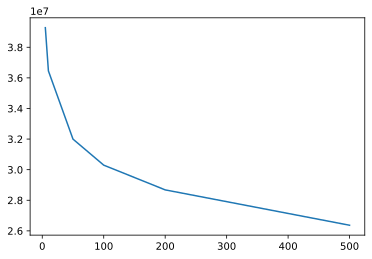

In [66]:
inertia = pd.Series([clustering['inertia'] for k, clustering in elbow_dict.items()], index=elbow_dict.keys())
sns.lineplot(x=inertia.index, y=inertia)

In [67]:
elbow_dict[100]['user_cluster'].value_counts()

87    3840
41    2218
55    1817
20    1703
63    1670
      ... 
36      74
56      60
45      59
88      38
77       1
Length: 100, dtype: int64

In [68]:
elbow_dict[500]['user_cluster'].value_counts()

336    2090
15     1384
179     850
362     765
297     747
       ... 
462       1
356       1
435       1
209       1
487       1
Length: 500, dtype: int64

In [69]:
from sklearn.neighbors import NearestNeighbors

In [70]:
nbrs = NearestNeighbors(n_neighbors=5)
nbrs.fit(jester_ratings_pivot_df.fillna(0))

NearestNeighbors()

In [71]:
jester_ratings_pivot_df.fillna(0).loc[[1]]

jokeId,5,7,8,13,15,16,17,18,19,20,...,141,142,143,144,145,146,147,148,149,150
userId,,,,,,,,,,,,,,,,,,,,,
1,0.219,-9.281,-9.281,-6.781,0.875,-9.656,-9.031,-7.469,-8.719,-9.156,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [72]:
dist, neighbours = nbrs.kneighbors(jester_ratings_pivot_df.fillna(0).loc[[1]])
neighbours[0].tolist()

[0, 44456, 100, 4214, 51129]

In [73]:
neighbours_ratings = jester_ratings_pivot_df.iloc[neighbours[0].tolist()[1:]]
neighbours_ratings

jokeId,5,7,8,13,15,16,17,18,19,20,...,141,142,143,144,145,146,147,148,149,150
userId,,,,,,,,,,,,,,,,,,,,,
47727,NaN,-5.938,-5.938,-6.188,-8.594,-7.844,-8.031,-7.562,-7.750,NaN,...,NaN,NaN,6.438,NaN,5.594,NaN,NaN,NaN,NaN,NaN
114,8.438,-5.594,-3.344,-3.750,2.594,-8.312,-5.469,-4.469,-2.531,-3.969,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4641,NaN,-4.531,-6.188,-2.375,-2.750,-1.938,-5.250,-3.625,1.156,NaN,...,NaN,NaN,NaN,6.031,NaN,NaN,NaN,7.125,6.719,NaN
55103,NaN,-6.875,-6.875,-6.875,-5.750,-5.719,-5.719,-5.719,-5.719,NaN,...,NaN,NaN,2.375,NaN,5.125,NaN,NaN,1.625,4.156,2.375


In [74]:
approriate_jokes = neighbours_ratings.mean()[neighbours_ratings.mean()>7].index.tolist()
approriate_jokes

[5, 27, 29, 50, 69, 105, 121, 122, 123, 125]

In [75]:
recommended_jokes = jester_ratings_pivot_df.loc[1,approriate_jokes]
recommended_jokes

jokeId
5      0.219
27     8.781
29     8.781
50     9.906
69     8.688
105    2.000
121    8.781
122      NaN
123    8.781
125      NaN
Name: 1, dtype: float64

In [76]:
recommended_jokes[recommended_jokes.isna()].index.tolist()

[122, 125]

In [77]:
for joke in jester_jokes_df[jester_jokes_df.jokeId.isin(recommended_jokes[~recommended_jokes.isna()].index.tolist())].jokeText:
    print(joke)
    print('---')

Q.	What's O. J. Simpson's Internet address? 
A.	Slash, slash, backslash, slash, slash, escape.

---
Clinton returns from a vacation in Arkansas and walks down  the
steps of Air Force One with two pigs under his arms.  At the bottom
of the steps, he says  to the honor guardsman, "These are genuine
Arkansas Razor-Back Hogs.  I got this one for Chelsea and this one for
Hillary."  

The guardsman replies, "Nice trade, Sir."

---
An old Scotsmen is sitting with a younger Scottish gentleman and says the boy. 
"Ah, lad look out that window. You see that stone wall there, I built it with
me own bare hands, placed every stone meself.  But do they call me MacGregor the
wall builder? No! 

He Takes a few sips of his beer then says, "Aye, and look out on that lake and 
eye that beautiful pier. I built it meself, laid every board and hammered each
nail but do they call me MacGregor the pier builder? No! 

He continues..."And lad, you see that road? That too I build with me own bare 
hands. Laid eve

In [78]:
for joke in jester_jokes_df[jester_jokes_df.jokeId.isin(recommended_jokes[recommended_jokes.isna()].index.tolist())].jokeText:
    print(joke)
    print('---')

An astronomer, a physicist and a mathematician (it is said) were holidaying in Scotland. Glancing from a train window, they observed a black sheep in the middle of a field. "How interesting," observed the astronomer, "All Scottish sheep are black!" To which the physicist responded, "No, no! Some Scottish sheep are black!" The mathematician gazed heavenward in supplication, and then intoned, "In Scotland there exists at least one field, containing at least one sheep, at least one side of which is black."
---
An American tourist goes into a restaurant in Spain and orders the specialty of the house. When his dinner arrives, he asks the waiter what it is. "These, senor," replied the waiter in broken English, "are the testicles of the bull killed in the ring today." The tourist swallowed hard but tasted the dish and thought it was delicious. So he comes back the next evening and orders the same item. When it is served, he says to the waiter, "These testicles...are much smaller than the ones